# CNN-Pretraining: Self-Supervised Learning with Autoencoder

Encoder-Decoder structure, 

input = output, 

l2-loss between output and input, 

decouple decoder, 

save encoder, 

load on RL-model and freeze 


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import numba as nb
import skimage as io
import sklearn as sk
import pandas as pd
import os

from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.feature_extraction import image
from sklearn.datasets import load_sample_image

from src.Map.Map import load_map
from src.model import Autoencoder, Autoencoder_flex
from src.utils import *
# from ...src.base.Environment import RandomTargetGenerator, RandomTagrgetGeneratorParams



2.4.1


![autoencoder](../../res/autoencoder.png)

![autoencoder_pretrained](../../res/pretrained.png)

(50, 50, 4)
0 90


TypeError: Invalid shape (32, 32, 8) for image data

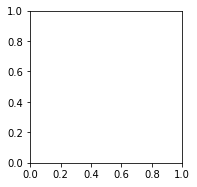

In [7]:
map_paths = ["res/manhattan32.png",
            "res/urban50.png"]

target_paths = ["res/manhattan_cpp_target.png",
               "res/urban_cpp_target.png"]

rotations = [90, 180, 270]
map_in = total_map = load_map(map_paths[1])
print(map_in)

mh32 = mpimg.imread(map_paths[0])
urb50 = mpimg.imread(map_paths[1])

mh_target = mpimg.imread(target_paths[0])
urb_target = mpimg.imread(target_paths[1])
print(urb_target.shape)

mh32 = np.concatenate((mh32, mh_target), axis=2)
urb50 = np.concatenate((urb50, urb_target), axis=2)

d={}

imgs = [mh32, urb50]

for i, angle in enumerate(rotations):
    print(i, angle)
    d["mh32_" + str(angle)] = np.rot90(mh32, i+1, (0,1))
    d["urb50_" + str(angle)] = np.rot90(urb50, i+1, (0,1))
    show_images([d["mh32_" + str(angle)], d["urb50_" + str(angle)]])
    imgs.append(d["mh32_" + str(angle)]) 
    imgs.append(d["urb50_" + str(angle)])

  
# Output Images
# plt.imshow(img[0])
# plt.imshow(img[1])

show_images(imgs)

# draw_map(map_path)

Patches shape: (14496, 17, 17, 4)
Patches shape: (14496, 17, 17, 4)


/home/fede/devel/MA/uavSim/CNN_Pretrain/src/utils.py:25: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images / float(cols)), n + 1)


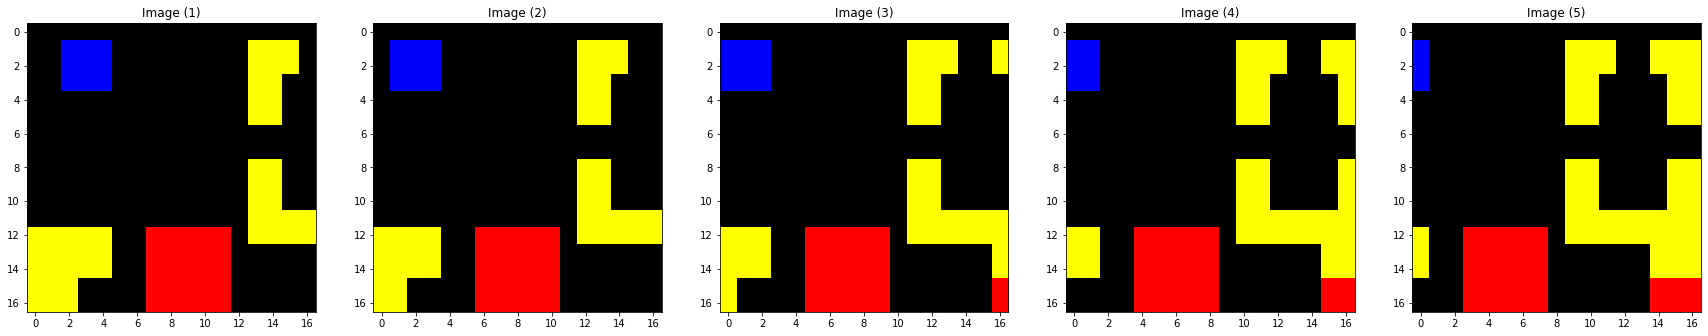

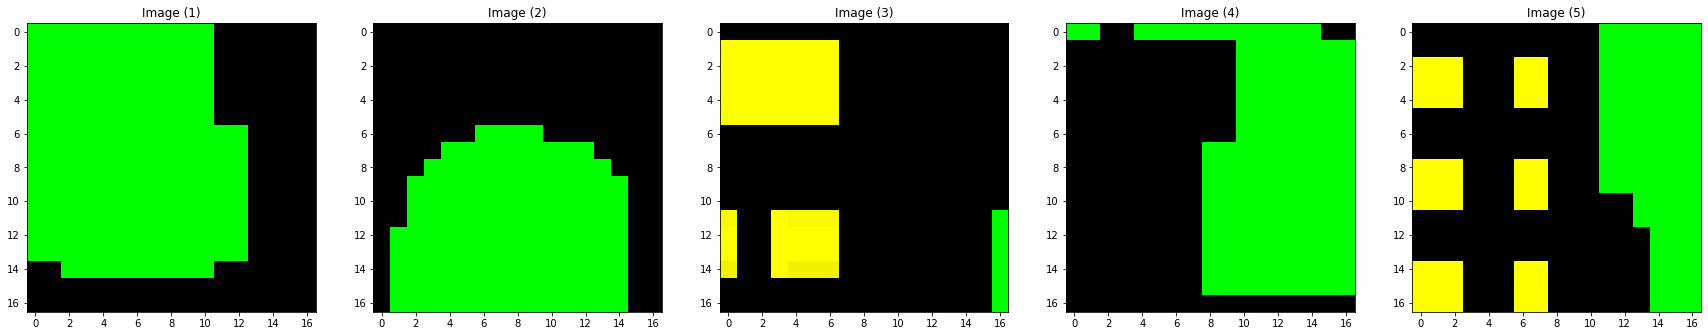

Training samples:(11596, 17, 17, 4)
Test samples:(2900, 17, 17, 4)
(17, 17, 4)


In [3]:
"""
Prepare Data
"""
patches = image.extract_patches_2d(imgs[0], (17, 17))
for i in range(len(imgs)-1):
    patches = np.concatenate((patches,
                              image.extract_patches_2d(imgs[i+1], (17, 17))),
                             axis=0)

print('Patches shape: {}'.format(patches.shape))

axis_array = np.arange(len(patches[0]))

shuffled_patches = sk.utils.shuffle(patches)

print('Patches shape: {}'.format(patches.shape))

n = int(len(patches)*0.8)


show_images(patches[:5])
show_images(shuffled_patches[:5])

X_train = shuffled_patches[:n]
X_test = shuffled_patches[-(len(patches)-n):]

print("Training samples:{}".format(X_train.shape))
print("Test samples:{}".format(X_test.shape))
print(X_train[0].shape)
# print(X_train[0][0])

In [4]:
configs = [[5,[2,3]],
           [4,[3,4]],
           [3,[3,4,5,6]]
          ]
name={}

for i in range(len(configs)):
    for n in range(len(configs[i][1])):
        ker_sz = configs[i][0]
        num_l = configs[i][1][n]
        print(ker_sz, num_l)
        
        dummy_sample = X_train[0][tf.newaxis, ...]
        name["autoenc_l"+str(num_l)+"k"+str(ker_sz)] = Autoencoder_flex(num_layers=num_l, kernel_size=ker_sz, inp_shape=X_train[0].shape)
        print(dummy_sample.shape, X_train[0].shape)
        name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].compile(optimizer='adam', loss='mse')
        name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].build(dummy_sample.shape)

        name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].summary()
        name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].encoder.summary()
        name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].decoder.summary()
        
#         name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].fit(patches, patches,
#                 epochs=1500,
#                 batch_size=32,
#                 shuffle=True,
#                 validation_data=(X_test, X_test))
        
        
        earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
        mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

        name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].fit(X_train, Y_train, batch_size=batch_size, epochs=1500, verbose=0, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.25)


# dummy_sample = X_train[0][tf.newaxis, ...]
# name["autoenc_l"+str(num_l)+"k"+str(ker_sz)] = Autoencoder_flex(num_layers=num_l, kernel_size=ker_sz, inp_shape=X_train[0].shape)
# print(dummy_sample.shape, X_train[0].shape)
# name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].compile(optimizer='adam', loss='mse')
# name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].build(dummy_sample.shape)

# name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].summary()
# name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].encoder.summary()
# name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].decoder.summary()

5 2
(1, 17, 17, 4) (17, 17, 4)
Model: "autoencoder_flex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 9, 9, 8)           1814      
_________________________________________________________________
decoder (Sequential)         (1, 17, 17, 4)            2412      
Total params: 4,226
Trainable params: 4,226
Non-trainable params: 0
_________________________________________________________________
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
0.-encoding_layer (Conv2D)   (None, 13, 13, 6)         606       
_________________________________________________________________
1.-encoding_layer (Conv2D)   (None, 9, 9, 8)           1208      
Total params: 1,814
Trainable params: 1,814
Non-trainable params: 0
________________________________________________________________

NameError: name 'Xtr_more' is not defined

In [ ]:
ker_sz = 5
num_l = 3

dummy_sample = X_train[0][tf.newaxis, ...]
name["autoenc_l"+str(num_l)+"k"+str(ker_sz)] = Autoencoder_flex(num_layers=num_l, kernel_size=ker_sz, inp_shape=X_train[0].shape)
print(dummy_sample.shape, X_train[0].shape)
name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].compile(optimizer='adam', loss='mse')
name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].build(dummy_sample.shape)

name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].summary()
name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].encoder.summary()
name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].decoder.summary()

name["autoenc_l"+str(num_l)+"k"+str(ker_sz)].fit(X_train, X_train,
                                                 epochs=1500,
                                                 batch_size=32,
                                                 shuffle=True,
                                                 validation_split=0.2)

In [ ]:
enc_imgs = name["autoenc_f"+str(ker_sz)].encoder(X_test)
print(enc_imgs.shape)

dec_imgs = name["autoenc_f"+str(ker_sz)].decoder(enc_imgs).numpy()
print(dec_imgs.shape)

plot_enc_layer(5, tf.squeeze(enc_imgs[:,:,0])) 

show_images(X_test[:10])
show_images(dec_imgs[:10])
compr = enc_imgs.shape[1]*enc_imgs.shape[2]*enc_imgs.shape[3]
decompr = dec_imgs.shape[1]*dec_imgs.shape[2]*dec_imgs.shape[3]
ratio = compr/decompr
print(" enc: {} \n org: {} \n compression ratio: {}".format(compr, decompr, ratio))


In [ ]:
autoenc.fit(X_train, X_train,
                epochs=1500,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

In [ ]:
enc_imgs = autoenc.encoder(X_test)
print(enc_imgs.shape)

dec_imgs = autoenc.decoder(enc_imgs).numpy()
print(dec_imgs.shape)

plot_enc_layer(5, tf.squeeze(enc_imgs[:,:,0])) 

show_images(X_test[:10])
show_images(dec_imgs[:10])
compr = enc_imgs.shape[1]*enc_imgs.shape[2]*enc_imgs.shape[3]
decompr = dec_imgs.shape[1]*dec_imgs.shape[2]*dec_imgs.shape[3]
ratio = compr/decompr
print(" enc: {} \n org: {} \n compression ratio: {}".format(compr, decompr, ratio))



In [ ]:
autoenc.save_weights('./saved_models/autoenc_{}'.format(ratio.2f))

In [ ]:
raise SystemExit("Stop right there!")


(X_train, _), (X_test, _) = mnist.load_data()
print("X_train", X_train.shape)
print("X_test", X_test.shape)

# print(X_train[0])

def pre_process(X):
    X = X.astype('float32') /255.0
    X = X[..., tf.newaxis]
    return X

X_train  =  pre_process(X_train)
X_test  =  pre_process(X_test)

print("X_train", X_train.shape)
print("X_test", X_test.shape)

print(X_train[0].shape)




In [ ]:

num_model = Autoencoder_flex(num_layers=4, inp_shape=X_train[0].shape, kernel_size=5)
num_model.compile(optimizer='adam', loss='mse')

num_model.fit(X_train, X_train,
                epochs=1,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))


In [ ]:
num_model.encoder.summary()
num_model.decoder.summary()

In [ ]:
enc_imgs = num_model.encoder(X_test).numpy()
print(enc_imgs.shape)

dec_imgs = num_model.decoder(enc_imgs).numpy()
print(dec_imgs.shape)

plot_bw_figs(10, tf.squeeze(enc_imgs[:,:,0]), 
             tf.squeeze(dec_imgs),  
             tf.squeeze(X_test))
print("enc: {} \n org: {}".format(16*16*8, 28*28))
